Data Loader

In [10]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip images
    transforms.RandomRotation(10),     # Randomly rotate images'
    transforms.ToTensor(),             # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load datasets from folders
train_data = datasets.ImageFolder(root=r'C:\Users\devad\OneDrive\Desktop\Glaucoma detection\eyepac-light-v2-512-jpg\train', transform=transform)
val_data = datasets.ImageFolder(root=r'C:\Users\devad\OneDrive\Desktop\Glaucoma detection\eyepac-light-v2-512-jpg\validation', transform=transform)
test_data = datasets.ImageFolder(root=r'C:\Users\devad\OneDrive\Desktop\Glaucoma detection\eyepac-light-v2-512-jpg\test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Confirm class-to-folder mapping
print("Class-to-Index Mapping:", train_data.class_to_idx)
# Output should map: {'NRG': 0, 'RG': 1}

# Print the number of images in the training and validation sets
print("Number of training images:", len(train_data))
print("Number of validation images:", len(val_data))


Class-to-Index Mapping: {'NRG': 0, 'RG': 1}
Number of training images: 8000
Number of validation images: 770


Model Define

In [3]:
import torch
import torch.nn as nn
from torchvision import models

# Load pre-trained ResNet
model = models.resnet34(pretrained=True)

# Modify the fully connected layer for binary classification
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),  # Intermediate layer
    nn.ReLU(),                             # Activation
    nn.Dropout(0.4),                       # Dropout for regularization
    nn.Linear(512, 2)                      # Output layer for 2 classes: NRG and RG
)


c:\Users\devad\Downloads\conda\envs\dev_1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\devad\Downloads\conda\envs\dev_1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification (even with 2 classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [17]:
import torch
import torch.optim as optim
import pickle
import numpy as np
from tqdm import tqdm  # Importing tqdm for progress bars

# Assume model, criterion, train_loader, optimizer are already defined

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Clear GPU VRAM before starting training (to ensure no leftover memory)
torch.cuda.empty_cache()

# Training loop
num_epochs = 20
best_train_loss = float('inf')

# Wrap the epochs with tqdm for progress tracking
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Wrap the train_loader with tqdm to show progress for each batch
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as batch_bar:
        for images, labels in batch_bar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update the tqdm progress bar with current loss
            batch_bar.set_postfix({"Loss": running_loss / (batch_bar.n + 1)})

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

    # Save the model if the current loss is the lowest
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        best_model = model.state_dict()  # Save the best model weights
        # Save weights
        torch.save(model.state_dict(), r'C:\Users\devad\OneDrive\Desktop\Glaucoma detection\Models\model_weights_34.pth')  # Save model weights
        # Optionally, save features in numpy format
        # np.save(r'C:\Users\devad\OneDrive\Desktop\Glaucoma detection\Models\model_features.npy', best_model)
        torch.cuda.empty_cache()
        with open(r'C:\Users\devad\OneDrive\Desktop\Glaucoma detection\Models\model_34.pkl', 'wb') as f:
            pickle.dump(model, f)
        print("Only best is saved chill")

# Load the best model (optional)
model.load_state_dict(best_model)


Epoch 1/20: 100%|██████████| 250/250 [01:27<00:00,  2.85batch/s, Loss=0.139]


Epoch 1, Training Loss: 0.1390
Only best is saved chill


Epoch 2/20: 100%|██████████| 250/250 [01:15<00:00,  3.33batch/s, Loss=0.116]


Epoch 2, Training Loss: 0.1160
Only best is saved chill


Epoch 3/20: 100%|██████████| 250/250 [01:16<00:00,  3.27batch/s, Loss=0.119]


Epoch 3, Training Loss: 0.1186


Epoch 4/20: 100%|██████████| 250/250 [01:16<00:00,  3.28batch/s, Loss=0.109]


Epoch 4, Training Loss: 0.1093
Only best is saved chill


Epoch 5/20: 100%|██████████| 250/250 [01:15<00:00,  3.31batch/s, Loss=0.111]


Epoch 5, Training Loss: 0.1107


Epoch 6/20: 100%|██████████| 250/250 [01:15<00:00,  3.30batch/s, Loss=0.115] 


Epoch 6, Training Loss: 0.1149


Epoch 7/20: 100%|██████████| 250/250 [03:41<00:00,  1.13batch/s, Loss=0.104] 


Epoch 7, Training Loss: 0.1044
Only best is saved chill


Epoch 8/20: 100%|██████████| 250/250 [04:39<00:00,  1.12s/batch, Loss=0.0954]


Epoch 8, Training Loss: 0.0954
Only best is saved chill


Epoch 9/20: 100%|██████████| 250/250 [03:28<00:00,  1.20batch/s, Loss=0.101] 


Epoch 9, Training Loss: 0.1005


Epoch 10/20: 100%|██████████| 250/250 [01:14<00:00,  3.35batch/s, Loss=0.0983]


Epoch 10, Training Loss: 0.0983


Epoch 11/20: 100%|██████████| 250/250 [01:15<00:00,  3.33batch/s, Loss=0.09]  


Epoch 11, Training Loss: 0.0900
Only best is saved chill


Epoch 12/20: 100%|██████████| 250/250 [01:16<00:00,  3.28batch/s, Loss=0.0888]


Epoch 12, Training Loss: 0.0888
Only best is saved chill


Epoch 13/20: 100%|██████████| 250/250 [01:16<00:00,  3.27batch/s, Loss=0.085] 


Epoch 13, Training Loss: 0.0850
Only best is saved chill


Epoch 14/20: 100%|██████████| 250/250 [01:17<00:00,  3.24batch/s, Loss=0.0812]


Epoch 14, Training Loss: 0.0812
Only best is saved chill


Epoch 15/20: 100%|██████████| 250/250 [01:19<00:00,  3.14batch/s, Loss=0.0693]


Epoch 15, Training Loss: 0.0693
Only best is saved chill


Epoch 16/20: 100%|██████████| 250/250 [01:20<00:00,  3.09batch/s, Loss=0.0718]


Epoch 16, Training Loss: 0.0718


Epoch 17/20: 100%|██████████| 250/250 [01:16<00:00,  3.28batch/s, Loss=0.0661]


Epoch 17, Training Loss: 0.0661
Only best is saved chill


Epoch 18/20: 100%|██████████| 250/250 [01:16<00:00,  3.25batch/s, Loss=0.0708]


Epoch 18, Training Loss: 0.0708


Epoch 19/20: 100%|██████████| 250/250 [01:17<00:00,  3.21batch/s, Loss=0.0623]


Epoch 19, Training Loss: 0.0623
Only best is saved chill


Epoch 20/20: 100%|██████████| 250/250 [01:16<00:00,  3.27batch/s, Loss=0.0579]


Epoch 20, Training Loss: 0.0579
Only best is saved chill


<All keys matched successfully>

In [11]:
import torch
import pickle
import numpy as np

# Load the saved model and weights
with open(r'C:\Users\devad\OneDrive\Desktop\Glaucoma detection\Models\model_34.pkl', 'rb') as f:
    model = pickle.load(f)

# Load the saved weights
model.load_state_dict(torch.load(r'C:\Users\devad\OneDrive\Desktop\Glaucoma detection\Models\model_weights_34.pth'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Assuming val_loader is already defined

# Validate the model
model.eval()
val_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_val_loss = val_loss / len(val_loader)
val_accuracy = 100 * correct / total
print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


C:\Users\devad\AppData\Local\Temp\ipykernel_18352\2778258449.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'C:\Users\devad\OneDrive\

Validation Loss: 0.2908, Validation Accuracy: 93.64%


Confusion Matrix:


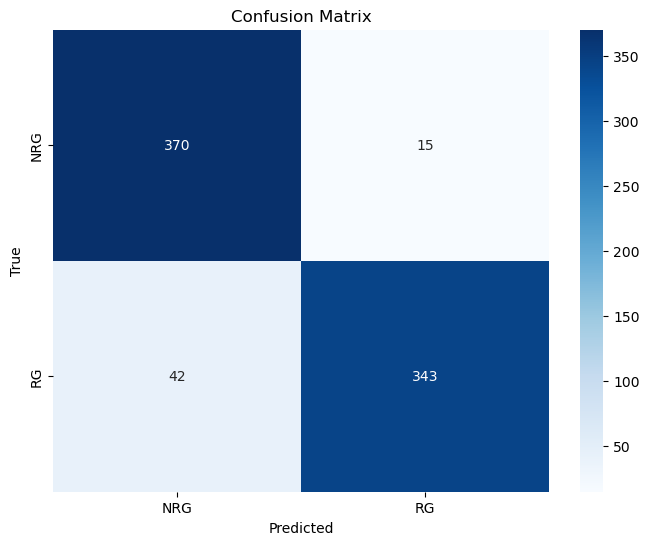

Classification Report:
              precision    recall  f1-score   support

         NRG       0.90      0.96      0.93       385
          RG       0.96      0.89      0.92       385

    accuracy                           0.93       770
   macro avg       0.93      0.93      0.93       770
weighted avg       0.93      0.93      0.93       770



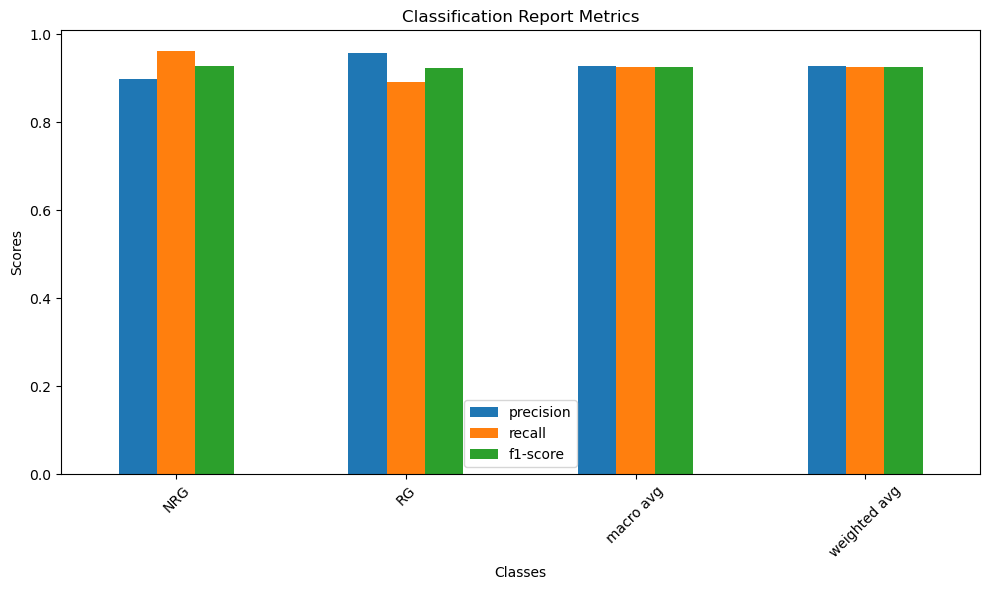

In [19]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Set the model to evaluation mode
model.eval()

# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# Perform inference on the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:")
report = classification_report(y_true, y_pred, target_names=train_data.classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Convert the report dictionary into a DataFrame
report_df = pd.DataFrame(report).transpose()

# Ensure that we're only plotting metrics (precision, recall, and f1-score) and not accuracy or support
# Filter out rows related to accuracy and support
metrics_df = report_df.drop(['accuracy'], axis=0, errors='ignore')

# Plot precision, recall, and f1-score for each class
metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Classification Report Metrics')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
import torch.nn as nn
from torchvision import models

# Load ResNet50 pretrained on ImageNet
model_resnet50 = models.resnet50(pretrained=True)

# Modify the fully connected layer for binary classification (NRG vs RG)
model_resnet50.fc = nn.Sequential(
    nn.Linear(model_resnet50.fc.in_features, 512),  # Add an intermediate layer
    nn.ReLU(),
    nn.Dropout(0.4),                               # Dropout for regularization
    nn.Linear(512, 2)                              # Output layer for 2 classes
)


c:\Users\devad\Downloads\conda\envs\dev_1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\devad\Downloads\conda\envs\dev_1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
import torch

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model_resnet50.parameters(), lr=0.001)


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet50.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
# Clear GPU VRAM before starting training (to ensure no leftover memory)
torch.cuda.empty_cache()

# Training loop
num_epochs = 20
best_train_loss = float('inf')

# Wrap the epochs with tqdm for progress tracking
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Wrap the train_loader with tqdm to show progress for each batch
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as batch_bar:
        for images, labels in batch_bar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update the tqdm progress bar with current loss
            batch_bar.set_postfix({"Loss": running_loss / (batch_bar.n + 1)})

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

    # Save the model if the current loss is the lowest
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        best_model = model.state_dict()  # Save the best model weights
        # Save weights
        torch.save(model.state_dict(), r'C:\Users\devad\OneDrive\Desktop\Glaucoma detection\Models\model_weights_50.pth')  # Save model weights
        # Optionally, save features in numpy format
        # np.save(r'C:\Users\devad\OneDrive\Desktop\Glaucoma detection\Models\model_features.npy', best_model)
        torch.cuda.empty_cache()
        with open(r'C:\Users\devad\OneDrive\Desktop\Glaucoma detection\Models\model_50.pkl', 'wb') as f:
            pickle.dump(model, f)
        print("Only best is saved chill")

# Load the best model (optional)
model.load_state_dict(best_model)


Epoch 1/20: 100%|██████████| 250/250 [01:27<00:00,  2.86batch/s, Loss=0.0627]


Epoch 1, Training Loss: 0.0627
Only best is saved chill


Epoch 2/20: 100%|██████████| 250/250 [01:20<00:00,  3.12batch/s, Loss=0.0614]


Epoch 2, Training Loss: 0.0614
Only best is saved chill


Epoch 3/20: 100%|██████████| 250/250 [01:20<00:00,  3.11batch/s, Loss=0.061] 


Epoch 3, Training Loss: 0.0610
Only best is saved chill


Epoch 4/20: 100%|██████████| 250/250 [01:25<00:00,  2.91batch/s, Loss=0.0634]


Epoch 4, Training Loss: 0.0634


Epoch 5/20: 100%|██████████| 250/250 [03:39<00:00,  1.14batch/s, Loss=0.0605]


Epoch 5, Training Loss: 0.0605
Only best is saved chill


Epoch 6/20: 100%|██████████| 250/250 [02:12<00:00,  1.88batch/s, Loss=0.0562]


Epoch 6, Training Loss: 0.0562
Only best is saved chill


Epoch 7/20: 100%|██████████| 250/250 [01:22<00:00,  3.03batch/s, Loss=0.0547]


Epoch 7, Training Loss: 0.0547
Only best is saved chill


Epoch 8/20: 100%|██████████| 250/250 [01:20<00:00,  3.09batch/s, Loss=0.0616]


Epoch 8, Training Loss: 0.0616


Epoch 9/20: 100%|██████████| 250/250 [01:22<00:00,  3.03batch/s, Loss=0.0572]


Epoch 9, Training Loss: 0.0572


Epoch 10/20: 100%|██████████| 250/250 [01:24<00:00,  2.95batch/s, Loss=0.0586]


Epoch 10, Training Loss: 0.0586


Epoch 11/20: 100%|██████████| 250/250 [01:18<00:00,  3.18batch/s, Loss=0.0634]


Epoch 11, Training Loss: 0.0634


Epoch 12/20: 100%|██████████| 250/250 [01:15<00:00,  3.31batch/s, Loss=0.0557]


Epoch 12, Training Loss: 0.0557


Epoch 13/20: 100%|██████████| 250/250 [01:13<00:00,  3.41batch/s, Loss=0.0545]


Epoch 13, Training Loss: 0.0545
Only best is saved chill


Epoch 14/20: 100%|██████████| 250/250 [01:18<00:00,  3.20batch/s, Loss=0.0609]


Epoch 14, Training Loss: 0.0609


Epoch 15/20: 100%|██████████| 250/250 [01:16<00:00,  3.25batch/s, Loss=0.0592]


Epoch 15, Training Loss: 0.0592


Epoch 16/20: 100%|██████████| 250/250 [01:15<00:00,  3.29batch/s, Loss=0.063] 


Epoch 16, Training Loss: 0.0630


Epoch 17/20: 100%|██████████| 250/250 [01:14<00:00,  3.36batch/s, Loss=0.058] 


Epoch 17, Training Loss: 0.0580


Epoch 18/20: 100%|██████████| 250/250 [01:14<00:00,  3.36batch/s, Loss=0.0647]


Epoch 18, Training Loss: 0.0647


Epoch 19/20: 100%|██████████| 250/250 [01:14<00:00,  3.37batch/s, Loss=0.0594]


Epoch 19, Training Loss: 0.0594


Epoch 20/20: 100%|██████████| 250/250 [01:14<00:00,  3.37batch/s, Loss=0.0637]

Epoch 20, Training Loss: 0.0637


<All keys matched successfully>

C:\Users\devad\AppData\Local\Temp\ipykernel_18352\1097968529.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'C:\Users\devad\OneDrive\

Validation Loss: 0.2643, Validation Accuracy: 93.25%


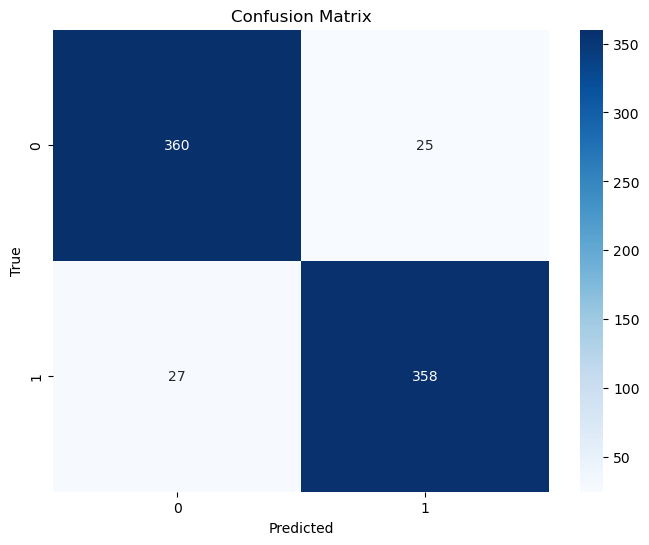


Normalized Confusion Matrix (percentages):
 tensor([[0.9351, 0.0649],
        [0.0701, 0.9299]])


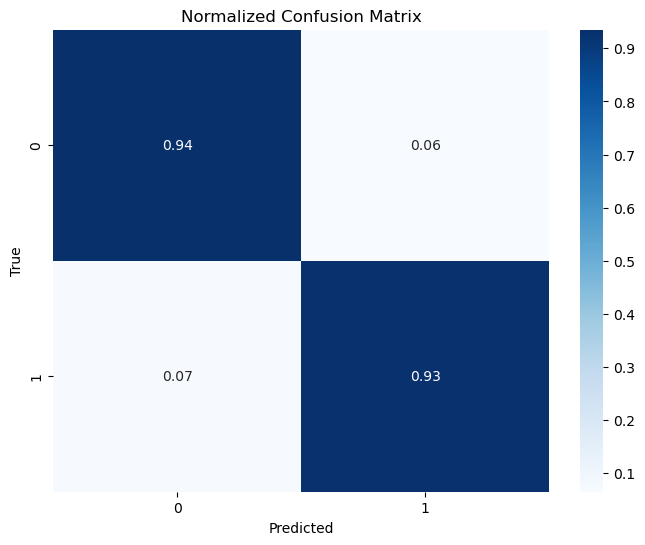

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.94      0.93       385
     Class 1       0.93      0.93      0.93       385

    accuracy                           0.93       770
   macro avg       0.93      0.93      0.93       770
weighted avg       0.93      0.93      0.93       770



In [15]:
import torch
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Load the saved model and weights
with open(r'C:\Users\devad\OneDrive\Desktop\Glaucoma detection\Models\model_50.pkl', 'rb') as f:
    model = pickle.load(f)

# Load the saved weights
model.load_state_dict(torch.load(r'C:\Users\devad\OneDrive\Desktop\Glaucoma detection\Models\model_weights_50.pth'))

# Define the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Assuming val_loader and criterion are already defined
model.eval()
val_loss = 0.0
correct = 0
total = 0
num_classes = 2  # Update this based on the number of classes in your dataset
confusion_matrix = torch.zeros((num_classes, num_classes), dtype=torch.int64)  # Initialize confusion matrix

# Lists to store ground truth labels and predictions
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Prediction and accuracy calculation
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update confusion matrix
        for i in range(len(labels)):
            true_label = labels[i]
            pred_label = predicted[i]
            confusion_matrix[true_label, pred_label] += 1

        # Append to lists for classification report
        y_true.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy
        y_pred.extend(predicted.cpu().numpy())  # Move predictions to CPU and convert to numpy

# Calculate average loss and accuracy
avg_val_loss = val_loss / len(val_loader)
val_accuracy = 100 * correct / total

# Print validation metrics
print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Generate and display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Normalize the confusion matrix for percentages
confusion_matrix_normalized = confusion_matrix.float() / confusion_matrix.sum(dim=1, keepdim=True)
print("\nNormalized Confusion Matrix (percentages):\n", confusion_matrix_normalized)

# Display the normalized confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
target_names = ['Class 0', 'Class 1']  # Replace with actual class names if available
print(classification_report(y_true, y_pred, target_names=target_names))
